<H1> 서울시 평균 기온 예측 해커톤

- https://dacon.io/competitions/official/236200/data

-  회귀

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 평균 기온 맞추기

## 데이터 살피기

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 파일 경로
#file_path = '/content/drive/MyDrive/skt/open/sample_submission.csv'
file_path = '/content/drive/MyDrive/skt/open/train.csv'

# CSV 파일을 데이터프레임으로 읽기
df = pd.read_csv(file_path)

# 데이터프레임 확인
df.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [ ]:
# 전체 확인
df.shape

(23011, 11)

In [ ]:
# 결측치 개수 확인
df.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64


## 결측치 처리

*   최고, 최저 기온 : 이전 이후 날짜에서의 값의 평균으로 대체
*   일교차: 최고, 최저 기온의 차이
* 강수량: 0으로 대체
* 평균풍속:앞 뒤 날짜에서 평균
* 일조합, 일사합, 일조율 : 0으로 대체



In [ ]:
data = df

참고

interpolate: 이 메서드는 연속된 데이터에서 결측치를 보간하는 데 사용됩니다. df['최고기온'].interpolate()는 최고기온 열에서 결측치를 보간하여 채우는 역할을 합니다. interpolate 메서드는 데이터가 시계열이나 순차적인 경우에 특히 유용합니다.


shift: 이 메서드는 시계열 데이터에서 현재 행을 기준으로 이전이나 다음 행의 값을 가져올 때 사용됩니다. df['평균풍속'].shift(-1)은 평균풍속 열에서 현재 행을 기준으로 다음 행의 값을 가져오는 역할을 합니다. -1은 다음 행을 의미합니다.

In [ ]:
#df['일시'] = pd.to_datetime(df['일시'])  # '일시' 열을 날짜 형식으로 변환

# 최고기온과 최저기온 결측치 처리
df['최고기온'] = df['최고기온'].fillna(df['최고기온'].interpolate())
df['최저기온'] = df['최저기온'].fillna(df['최저기온'].interpolate())
# 평균 풍속 결측치를 앞 뒤 날짜에서의 평균으로 대체
df['평균풍속'] = df['평균풍속'].fillna((df['평균풍속'].shift() + df['평균풍속'].shift(-1)) / 2)

# 일교차 결측치 처리
df['일교차'] = df['일교차'].fillna(df['최고기온'] - df['최저기온'])

# 결과 출력
df.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


### 평균 습도 확인

In [ ]:
# 평균습도가 80 이하인 행의 강수량 결측치를 0으로 처리
df.loc[df['평균습도'] <= 80, '강수량'] = df.loc[df['평균습도'] <= 80, '강수량'].fillna(0)
df.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,NaN,NaN,-4.6


In [ ]:
df.isnull().sum()

일시         0
최고기온       0
최저기온       0
일교차        0
강수량      483
평균습도       0
평균풍속       2
일조합      118
일사합     4862
일조율      366
평균기온       0
dtype: int64

In [ ]:
# 강수량이 nan인 행 출력
nan_rows = df[df['강수량'].isna()]
nan_rows

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
183,1960-07-02,29.8,20.7,9.1,NaN,86.3,1.4,6.2,NaN,NaN,24.8
186,1960-07-05,30.6,20.4,10.2,NaN,86.0,1.3,6.4,NaN,NaN,24.4
194,1960-07-13,29.0,22.8,6.2,NaN,84.3,3.1,2.6,NaN,NaN,25.3
196,1960-07-15,29.2,22.6,6.6,NaN,85.0,1.3,4.4,NaN,NaN,25.5
212,1960-07-31,30.5,24.3,6.2,NaN,84.3,2.4,7.2,NaN,NaN,26.3
...,...,...,...,...,...,...,...,...,...,...,...
22815,2022-06-19,25.1,22.3,2.8,NaN,81.6,1.4,0.0,5.06,0.0,23.4
22821,2022-06-25,30.5,21.5,9.0,NaN,80.4,2.8,3.0,17.55,20.3,26.0
22822,2022-06-26,28.1,24.8,3.3,NaN,82.1,2.6,0.0,3.00,0.0,26.5
22827,2022-07-01,30.9,21.9,9.0,NaN,83.3,2.1,7.2,21.53,49.0,26.6


In [ ]:
# 강수량이 nan이고 평균습도가 90 이상인 행 출력
selected_rows = df[(df['강수량'].isna()) & (df['평균습도'] >= 90)]
selected_rows.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
2593,1967-02-06,1.0,-2.2,3.2,NaN,91.8,1.6,0.4,NaN,3.8,-0.8
3246,1968-11-20,13.2,7.8,5.4,NaN,90.5,1.3,0.2,NaN,2.0,9.8
4026,1971-01-09,3.0,-2.6,5.6,NaN,90.0,1.3,0.0,NaN,0.0,-0.4
4387,1972-01-05,2.0,-0.7,2.7,NaN,91.8,2.3,0.0,NaN,0.0,0.7
4744,1972-12-27,5.0,0.0,5.0,NaN,92.8,1.3,0.0,NaN,0.0,2.3


In [ ]:
# 강수량이 nan인 행 중에서 가장 높은 평균습도 찾기
max_humidity = df[df['강수량'].isna()]['평균습도'].max()
max_humidity

92.8

- 0으로 처리


In [ ]:
# 결측치를 0으로 처리
df.fillna(0, inplace=True)

In [ ]:
df.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,0.0,0.0,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,0.0,0.0,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,0.0,0.0,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,0.0,0.0,7.5
4,1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,0.0,0.0,-4.6


## 일시 분리하기

In [ ]:
# Date 열을 Year,Month,Day 열로 분리하고 Date 열을 Drop
df['년도'] = pd.to_datetime(df['일시']).dt.year
df['월'] = pd.to_datetime(df['일시']).dt.month
df['일'] = pd.to_datetime(df['일시']).dt.day

# 변경된 DataFrame 출력
df.drop(columns=['일시'], inplace=True)
df

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년도,월,일
0,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,0.00,0.0,-1.6,1960,1,1
1,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,0.00,0.0,-1.9,1960,1,2
2,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,0.00,0.0,4.0,1960,1,3
3,10.8,1.2,9.6,0.0,79.7,4.4,2.6,0.00,0.0,7.5,1960,1,4
4,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,0.00,0.0,-4.6,1960,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23006,3.3,-7.3,10.6,0.0,69.8,1.8,8.8,10.25,91.7,-2.6,2022,12,27
23007,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3,2022,12,28
23008,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9,2022,12,29
23009,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8,2022,12,30


## 상관관계 보기

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


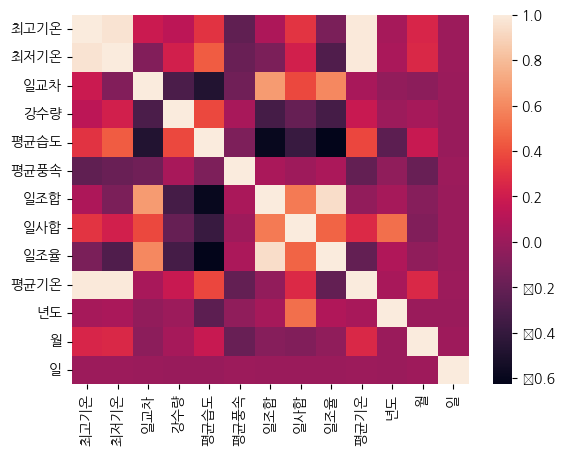

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.heatmap(df.corr())

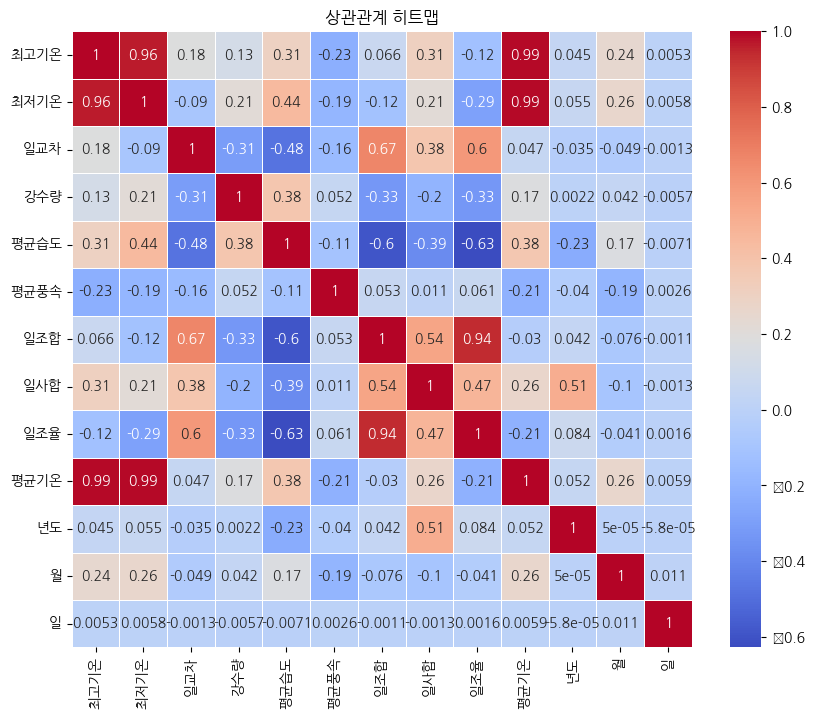

In [ ]:
# 상관관계 행렬 계산
correlation_matrix = df.corr()

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('상관관계 히트맵')
plt.show()

## 특징값 뽑

In [ ]:
# 평균기온과의 상관관계가 높은 변수 선택 (절댓값 기준 내림차순 정렬 후 상위 5개 선택)
top_correlated_variables = correlation_matrix['평균기온'].abs().sort_values(ascending=False)[:6].index.tolist()
top_correlated_variables

['평균기온', '최고기온', '최저기온', '평균습도', '일사합', '월']

In [ ]:
# 선택된 변수들로 데이터프레임 생성
selected_df = df[top_correlated_variables]

# 결측치를 0으로 처리
selected_df.fillna(0, inplace=True)


<ipython-input-89-e402e90359fe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.fillna(0, inplace=True)


In [ ]:
selected_df.head()

,평균기온,최고기온,최저기온,평균습도,일사합,월
0,-1.6,2.2,-5.2,68.3,0.0,1
1,-1.9,1.2,-5.6,87.7,0.0,1
2,4.0,8.7,-2.1,81.3,0.0,1
3,7.5,10.8,1.2,79.7,0.0,1
4,-4.6,1.3,-8.2,44.0,0.0,1


## 데이터 분할

In [ ]:

# 종속 변수(y)와 독립 변수(x)로 데이터 분할
y = selected_df['평균기온']
X = selected_df.drop('평균기온', axis=1)


In [ ]:

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## 학습

In [ ]:
# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Explained Variance Score: {explained_var}')


Mean Squared Error: 0.2666674911451197
R^2 Score: 0.9975922355994024
Explained Variance Score: 0.9975923568735451


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


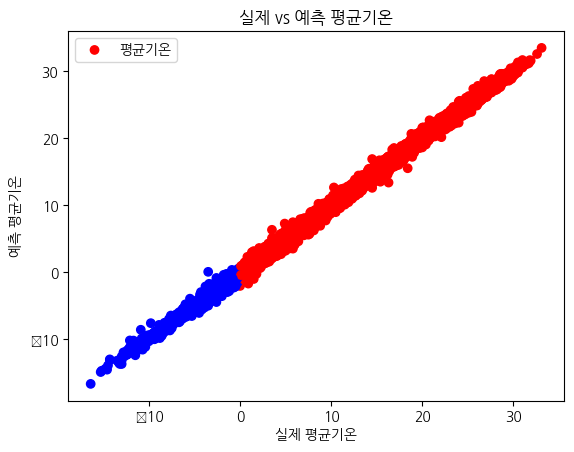

In [ ]:

# 예측 결과 시각화
plt.scatter(y_test, y_pred, c=['blue' if t < 0 else 'red' for t in y_test], label='평균기온')
plt.xlabel("실제 평균기온")
plt.ylabel("예측 평균기온")
plt.title("실제 vs 예측 평균기온")
plt.legend()
plt.show()

<ipython-input-39-f0420aedadde>:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


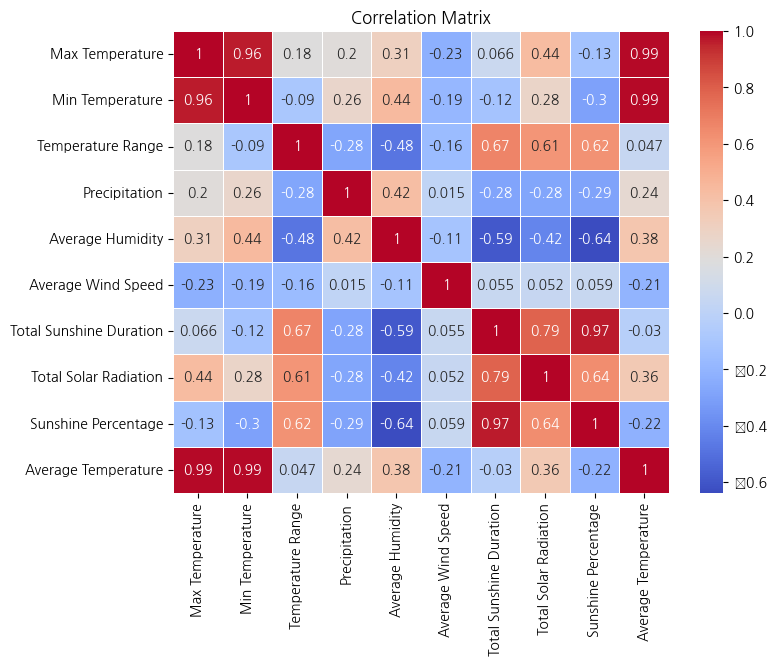

Linear : 114.11
GraidentBoost : 85.08
RandomForest : 86.04
KNN : 95.34


In [ ]:
# 일조합, 일조율 -> 강수량 예측
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
df=pd.read_csv(file_path)

# 1. 상관계수 맵
df.rename(columns={
    '일시': 'Date',
    '최고기온': 'Max Temperature',
    '최저기온': 'Min Temperature',
    '일교차': 'Temperature Range',
    '강수량': 'Precipitation',
    '평균습도': 'Average Humidity',
    '평균풍속': 'Average Wind Speed',
    '일조합': 'Total Sunshine Duration',
    '일사합': 'Total Solar Radiation',
    '일조율': 'Sunshine Percentage',
    '평균기온': 'Average Temperature'
}, inplace=True)
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# 2. 데이터 전처리
df=df.loc[:,['Date','Average Humidity','Total Solar Radiation','Sunshine Percentage']]

# 1) 결측치 처리
average_solar_radiation = df['Total Solar Radiation'].mean()
df['Total Solar Radiation'].fillna(average_solar_radiation, inplace=True)
average_solar_radiation = df['Sunshine Percentage'].mean()
df['Sunshine Percentage'].fillna(average_solar_radiation, inplace=True)

# 2) 날짜 데이터 처리
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df.drop(columns=['Date'], inplace=True)

# 학습, 타겟 데이터 분리
dfX = df.drop('Average Humidity', axis=1)
dfy = df['Average Humidity']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.2, random_state=42)

# 데이터 스케일링
from sklearn.preprocessing import RobustScaler
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
y_train = y_train.values
X_test = sc.transform(X_test)
y_test = y_test.values

# 머신러닝 모델별 예측(MSE)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

regressors={'Linear':LinearRegression(),
            'GraidentBoost':GradientBoostingRegressor(n_estimators=100, random_state=42),
            'RandomForest':RandomForestRegressor(n_estimators=100, random_state=42),
            'KNN':KNeighborsRegressor(n_neighbors=5)}

def regressor_predict(X_train,y_train,X_test,y_test):
    for name, regressor in regressors.items():
        regressor.fit(X_train, y_train)
        y_test = y_test.flatten()
        y_pred = regressor.predict(X_test)
        print(f"{name} : {mean_squared_error(y_test, y_pred):.2f}")

regressor_predict(X_train,y_train,X_test,y_test)

[머신러닝 모델별 예측 성능 결과]
Linear : 114.11
GraidentBoost : 85.08
RandomForest : 86.04
KNN : 95.34

<ipython-input-40-995f44cf1ad6>:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


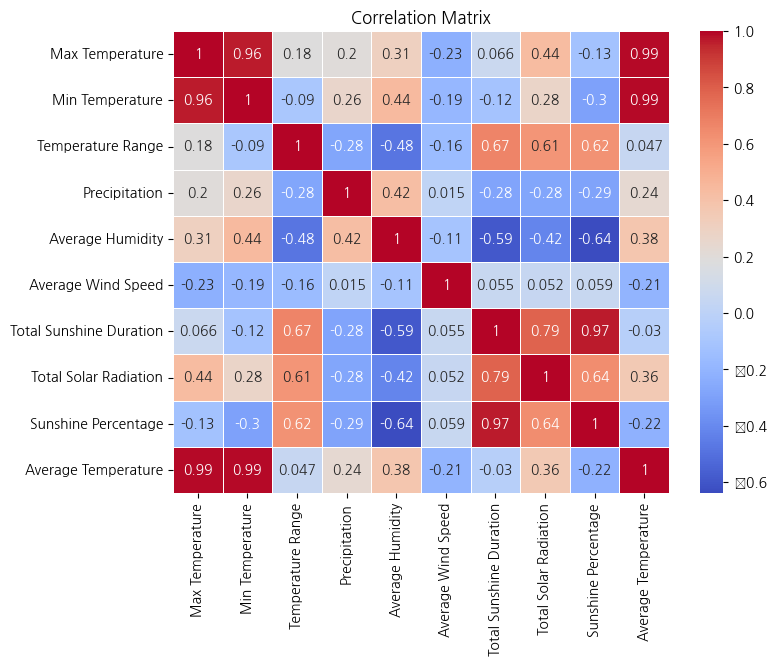

Linear : 118.20
GraidentBoost : 85.49
RandomForest : 86.67
KNN : 99.42


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 데이터 프레임 읽기
df = pd.read_csv(file_path)

# 컬럼명 변경
df.rename(columns={
    '일시': 'Date',
    '최고기온': 'Max Temperature',
    '최저기온': 'Min Temperature',
    '일교차': 'Temperature Range',
    '강수량': 'Precipitation',
    '평균습도': 'Average Humidity',
    '평균풍속': 'Average Wind Speed',
    '일조합': 'Total Sunshine Duration',
    '일사합': 'Total Solar Radiation',
    '일조율': 'Sunshine Percentage',
    '평균기온': 'Average Temperature'
}, inplace=True)

# 상관계수 맵
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# 데이터 전처리
df = df.loc[:, ['Date', 'Average Humidity', 'Total Solar Radiation', 'Sunshine Percentage']]

# 결측치 0으로 처리
df['Total Solar Radiation'].fillna(0, inplace=True)
df['Sunshine Percentage'].fillna(0, inplace=True)

# 날짜 데이터 처리
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df.drop(columns=['Date'], inplace=True)

# 학습, 타겟 데이터 분리
dfX = df.drop('Average Humidity', axis=1)
dfy = df['Average Humidity']

X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.2, random_state=42)

# 데이터 스케일링
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
y_train = y_train.values
X_test = sc.transform(X_test)
y_test = y_test.values

# 머신러닝 모델별 예측(MSE)
regressors = {'Linear': LinearRegression(),
              'GraidentBoost': GradientBoostingRegressor(n_estimators=100, random_state=42),
              'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
              'KNN': KNeighborsRegressor(n_neighbors=5)}

def regressor_predict(X_train, y_train, X_test, y_test):
    for name, regressor in regressors.items():
        regressor.fit(X_train, y_train)
        y_test = y_test.flatten()
        y_pred = regressor.predict(X_test)
        print(f"{name} : {mean_squared_error(y_test, y_pred):.2f}")

regressor_predict(X_train, y_train, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
<ipython-input-70-3a9c2a507bce>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.fillna(0, inplace=True)


Mean Squared Error: 97.91234303600969
R^2 Score: 0.5448796023329446
Explained Variance Score: 0.5449228813895592


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


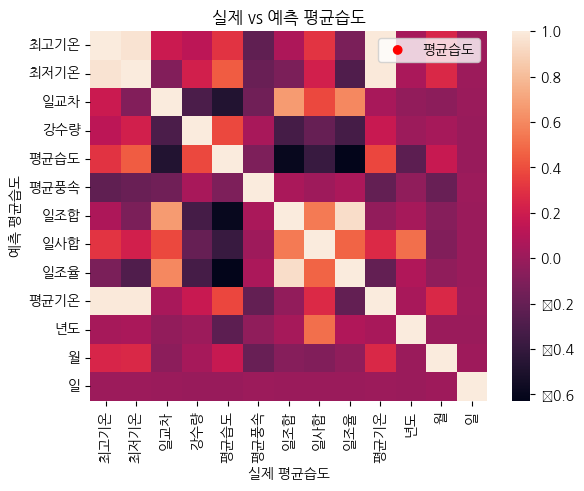

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 경로
file_path = '/content/drive/MyDrive/skt/open/train.csv'

# CSV 파일을 데이터프레임으로 읽기
df = pd.read_csv(file_path)

# 결측치 처리
df['최고기온'] = df['최고기온'].fillna(df['최고기온'].interpolate())
df['최저기온'] = df['최저기온'].fillna(df['최저기온'].interpolate())
df['평균풍속'] = df['평균풍속'].fillna((df['평균풍속'].shift() + df['평균풍속'].shift(-1)) / 2)
df['일교차'] = df['일교차'].fillna(df['최고기온'] - df['최저기온'])
df['강수량'] = df['강수량'].fillna(0)
df.fillna(0, inplace=True)

# 일시 분리
df['년도'] = pd.to_datetime(df['일시']).dt.year
df['월'] = pd.to_datetime(df['일시']).dt.month
df['일'] = pd.to_datetime(df['일시']).dt.day
df.drop(columns=['일시'], inplace=True)

# 상관관계 확인
plt.rcParams['font.family'] = 'NanumGothic'
sns.heatmap(df.corr())

# 특징값 선택
top_correlated_variables = df.corr()['평균습도'].abs().sort_values(ascending=False)[:6].index.tolist()
selected_df = df[top_correlated_variables]
selected_df.fillna(0, inplace=True)

# 데이터 분할
y = selected_df['평균습도']
X = selected_df.drop('평균습도', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Explained Variance Score: {explained_var}')

# 예측 결과 시각화
plt.scatter(y_test, y_pred, c=['blue' if t < 0 else 'red' for t in y_test], label='평균습도')
plt.xlabel("실제 평균습도")
plt.ylabel("예측 평균습도")
plt.title("실제 vs 예측 평균습도")
plt.legend()
plt.show()
